In [7]:

# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm

In [8]:
# تنظیم نمایش بهتر نمودارها و اعداد فارسی
# Set plot style and Persian numbers
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)

In [9]:
df = pd.read_csv('pima_cleaned.csv')

In [12]:
print("اطلاعات اولیه دیتاست:")
print(f"تعداد نمونه‌ها: {df.shape[0]}")
print(f"تعداد ویژگی‌ها: {df.shape[1] - 1}")
print("\nبررسی پنج نمونه اول:")
print(df.head())

اطلاعات اولیه دیتاست:
تعداد نمونه‌ها: 768
تعداد ویژگی‌ها: 8

بررسی پنج نمونه اول:
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.352941  0.670968       0.489796       0.304348  0.019832  0.314928   
1     0.058824  0.264516       0.428571       0.239130  0.019832  0.171779   
2     0.470588  0.896774       0.408163       0.173913  0.019832  0.104294   
3     0.058824  0.290323       0.428571       0.173913  0.096154  0.202454   
4     0.000000  0.600000       0.163265       0.304348  0.185096  0.509202   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.234415  0.483333        1  
1                  0.116567  0.166667        0  
2                  0.253629  0.183333        1  
3                  0.038002  0.000000        0  
4                  0.943638  0.200000        1  


In [14]:
# جدا کردن ویژگی هدف (دیابت) از بقیه ویژگی‌ها
# Separating the target feature (diabetes) from other features
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

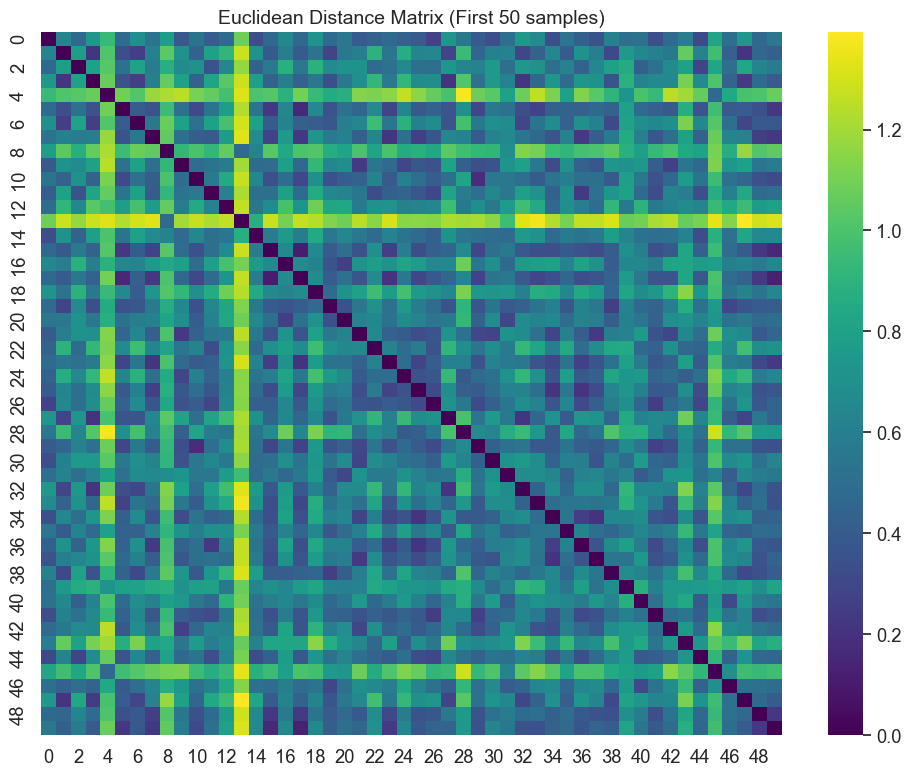

In [22]:
# محاسبه ماتریس فاصله اقلیدسی بین تمام نمونه‌ها
# Calculate Euclidean distance matrix between all samples
distance_matrix = pairwise_distances(X, metric='euclidean')

# نمایش ماتریس فاصله با نقشه حرارتی
# Display the distance matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix[:50, :50], cmap='viridis')
plt.title('Euclidean Distance Matrix (First 50 samples)', fontsize=14)
plt.tight_layout()